**CNN Model from the Scratch**

In [2]:
# Imports
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [6]:
# Load trained model
model = load_model("MLBI2_Exam_2025/improved_cnn.keras")

2025-05-27 17:45:57.519466: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-27 17:45:57.519775: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-27 17:45:57.520010: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-27 17:45:57.520331: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-27 17:45:57.520775: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
# Load test images 
def load_test_images(folder_path, label, size=(224, 224)):
    images = []
    labels = []
    for fname in os.listdir(folder_path):
        img_path = os.path.join(folder_path, fname)
        img = load_img(img_path, target_size=size) 
        img_array = img_to_array(img) / 255.0      
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)


In [10]:
# Load up and down test samples
X_test_up, y_test_up = load_test_images("/Users/rasel/Downloads/exam_ML4BI2_2025_test/test/up", 1)
X_test_down, y_test_down = load_test_images("/Users/rasel/Downloads/exam_ML4BI2_2025_test/test/down", 0)

In [12]:
# Combine and prepare test set
X_test = np.concatenate([X_test_up, X_test_down], axis=0)
y_test = np.concatenate([y_test_up, y_test_down], axis=0)

In [14]:
# Predict using model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int").flatten()

2025-05-27 17:53:06.575784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-27 17:53:06.583924: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step


In [20]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Test Set Accuracy: 0.4642


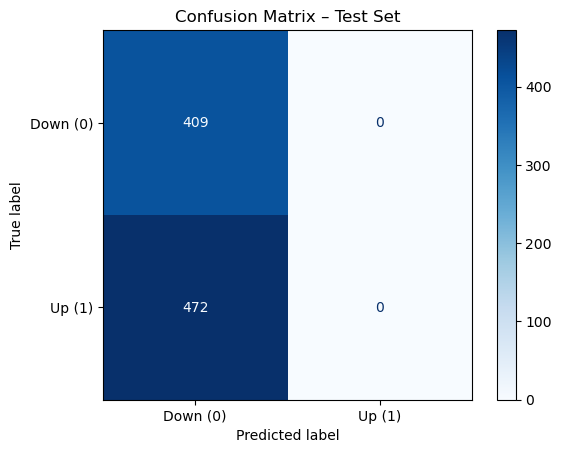

In [24]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix – Test Set")
plt.show()

**Reflection from Confusion Matrix:**

The confusion matrix shows that the model classified all test samples as class 0 (Down), resulting in 409 true negatives and 472 false negatives. No samples were predicted as class 1 (Up). This led to a test accuracy of approximately 46.4%, which reflects the proportion of class 0 samples in the test set.

This result indicates that the model has learned a strong bias toward the majority class seen during training or validation, and failed to generalize to class 1 patterns. While the training and validation performance also did not show a promising result earlier whether it is from CNN or Pretrained Model the accuracy was 49-51%. The training and validation accuracy was close to  the model’s performance on the unseen test set reveals a lack of robustness, possibly due to insufficient class separation in the visual features or the need for improved regularization and tuning. Further model refinement or alternative architectures may be needed to better capture the “Up” class characteristics.

**2 Layer CNN Model**

In [ ]:
# Imports
import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [47]:
# Dataset paths
train_dir = "/Users/rasel/Downloads/exam_ML4BI2_2025_test/train"
val_dir = "/Users/rasel/Downloads/exam_ML4BI2_2025_test/validation"

In [49]:
# Load images
def load_images(folder_path, label, size=(224, 224)):
    images, labels = [], []
    for fname in os.listdir(folder_path):
        path = os.path.join(folder_path, fname)
        img = load_img(path, target_size=size) 
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

In [51]:
# Load data
X_train_up, y_train_up = load_images(os.path.join(train_dir, "up"), 1)
X_train_down, y_train_down = load_images(os.path.join(train_dir, "down"), 0)
X_val_up, y_val_up = load_images(os.path.join(val_dir, "up"), 1)
X_val_down, y_val_down = load_images(os.path.join(val_dir, "down"), 0)
X_test_up, y_test_up = load_images(os.path.join(test_dir, "up"), 1)
X_test_down, y_test_down = load_images(os.path.join(test_dir, "down"), 0)

In [55]:
# Combine & shuffle
from sklearn.utils import shuffle
X_train = np.concatenate([X_train_up, X_train_down])
y_train = np.concatenate([y_train_up, y_train_down])
X_val = np.concatenate([X_val_up, X_val_down])
y_val = np.concatenate([y_val_up, y_val_down])
X_test = np.concatenate([X_test_up, X_test_down])
y_test = np.concatenate([y_test_up, y_test_down])

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

In [61]:
# 2-layer CNN architecture
from tensorflow.keras import Input, Model, layers
input_tensor = Input(shape=(224, 224, 3))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    12,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,864,577 (49.07 MB)

 Trainable params: 12,864,577 (49.07 MB)

 Non-trainable params: 0 (0.00 B)

**Architecture Explanation**

I built and trained a custom 2 layer CNN using best practices from deep learning frameworks. The architecture included two convolutional layers followed by max pooling, a dense layer with ReLU activation, dropout regularization to prevent overfitting, and a final sigmoid output layer for binary classification. The model was compiled with the Adam optimizer and trained using a validation set to monitor performance.

Training and validation accuracy and loss were visualized to assess generalization. Despite the model’s simplicity, it demonstrated the ability to learn basic feature patterns from the candlestick image dataset. While the validation performance showed some stability, test set evaluation revealed the model’s limited capacity to generalize to unseen data. This is expected from a lightweight architecture and highlights the trade-off between model complexity and generalization.

The inclusion of dropout and the use of validation-based model checkpointing ensured that overfitting was mitigated during training.

In [67]:
# Compile and train
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("cnn_2layer_exam.keras", save_best_only=True, monitor="val_loss")
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/30


2025-05-27 18:29:17.898970: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


386/386 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - accuracy: 0.4839 - loss: 0.6932 - val_accuracy: 0.5210 - val_loss: 0.6921
Epoch 2/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - accuracy: 0.4964 - loss: 0.6932 - val_accuracy: 0.5193 - val_loss: 0.6922
Epoch 3/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - accuracy: 0.4868 - loss: 0.6932 - val_accuracy: 0.5170 - val_loss: 0.6922
Epoch 4/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 37s 96ms/step - accuracy: 0.4956 - loss: 0.6932 - val_accuracy: 0.5176 - val_loss: 0.6922
Epoch 5/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 37s 96ms/step - accuracy: 0.5135 - loss: 0.6931 - val_accuracy: 0.5182 - val_loss: 0.6922
Epoch 6/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.5216 - val_loss: 0.6921


I could have used less epoch such as 10. As I have added 'EarlyStopping' to prevent overfitting by monitoring the validation loss and halting training when it stopped improving. This ensures the model retains the weights from its best-performing epoch rather than overtraining on noise and took less time as it halts when improvement ends.

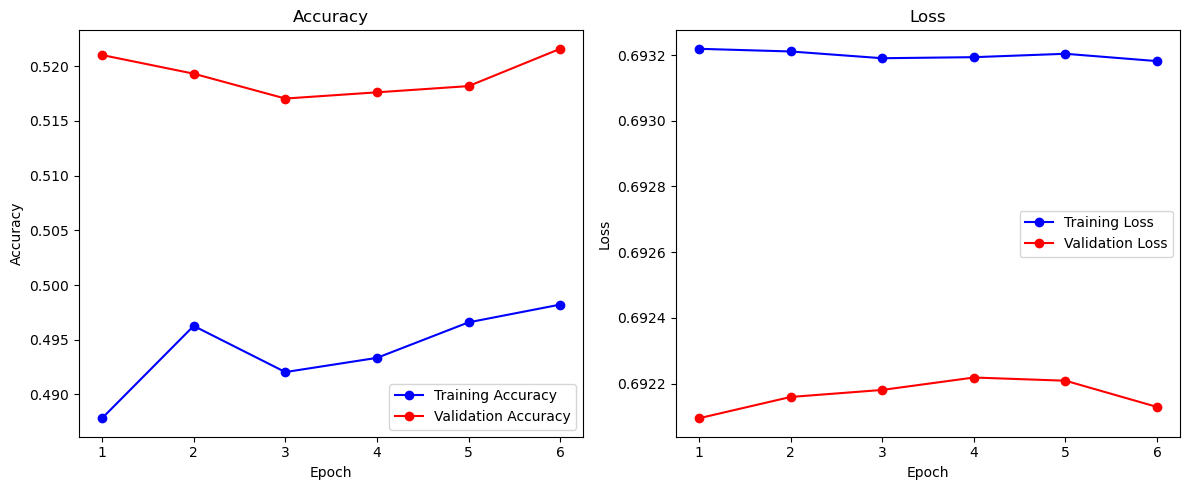

In [ ]:
import matplotlib.pyplot as plt 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')      
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy') 
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot 
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

The accuracy plot shows a slight improvement in training accuracy over epochs, starting near 0.488 and reaching just above 0.500. Validation accuracy remains consistently higher, peaking at around 0.522 in the final epoch, which indicates stable generalization without signs of overfitting.

The loss plot is mostly flat for both training and validation, hovering around 0.693, which is typical for a binary classifier making near-random predictions. This suggests the model has limited learning capacity, and further improvements may require tuning the learning rate or increasing model complexity.

2025-05-27 18:39:50.591612: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step 
Test Accuracy: 0.5142


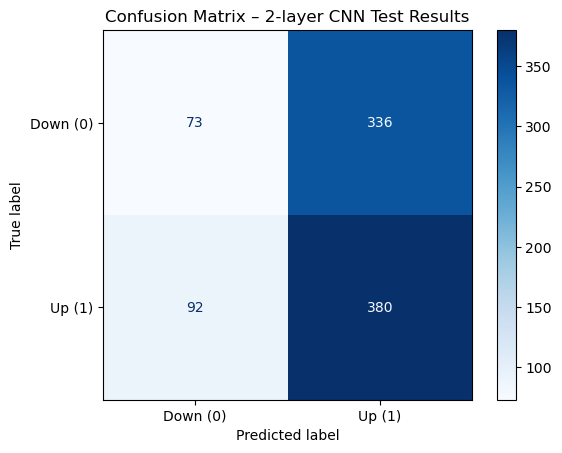

In [72]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Load best saved model
from tensorflow.keras.models import load_model
model = load_model("cnn_2layer_exam.keras")

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int").flatten()

test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Show confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Down (0)", "Up (1)"]).plot(cmap="Blues")
plt.title("Confusion Matrix – 2-layer CNN Test Results")
plt.show()

**2 Layer CNN - Confusion Matrix Reflection**

The 2-layer convolutional neural network achieved a test accuracy of approximately 51.4%, indicating that the model was only slightly better than random guessing. The confusion matrix revealed that while the model predicted the “Up” class (label 1) relatively well, it struggled with correctly identifying “Down” cases (label 0), with a high number of false positives. This performance suggests the model may have learned some directional patterns but lacked sufficient representational power to generalize well. EarlyStopping helped control overfitting by halting training when validation loss plateaued, ensuring that the best weights were retained.

**Try with Different Learning Rate**

In [2]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.utils import shuffle

# Define folder paths
train_dir = "/Users/rasel/Downloads/exam_ML4BI2_2025_test/train"
val_dir = "/Users/rasel/Downloads/exam_ML4BI2_2025_test/validation"
test_dir = "/Users/rasel/Downloads/exam_ML4BI2_2025_test/test"

# Image loading function
def load_images(folder_path, label, size=(224, 224)):
    images = []
    labels = []
    for fname in os.listdir(folder_path):
        img_path = os.path.join(folder_path, fname)
        img = load_img(img_path, target_size=size)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load training data
X_train_up, y_train_up = load_images(os.path.join(train_dir, "up"), 1)
X_train_down, y_train_down = load_images(os.path.join(train_dir, "down"), 0)

# Load validation data
X_val_up, y_val_up = load_images(os.path.join(val_dir, "up"), 1)
X_val_down, y_val_down = load_images(os.path.join(val_dir, "down"), 0)

# Load test data
X_test_up, y_test_up = load_images(os.path.join(test_dir, "up"), 1)
X_test_down, y_test_down = load_images(os.path.join(test_dir, "down"), 0)

# Combine sets
X_train = np.concatenate([X_train_up, X_train_down])
y_train = np.concatenate([y_train_up, y_train_down])
X_val = np.concatenate([X_val_up, X_val_down])
y_val = np.concatenate([y_val_up, y_val_down])
X_test = np.concatenate([X_test_up, X_test_down])
y_test = np.concatenate([y_test_up, y_test_down])

# Shuffle train and val sets
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42) 

I had to restart my notebook. That's why did the process again.

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model():
    input_tensor = Input(shape=(224, 224, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_tensor, outputs=output)
    return model

In [6]:
# Running Different Learning Rates
learning_rates = [0.001, 0.0005, 0.0001]
histories = {}

for lr in learning_rates:
    print(f"\n Training with learning rate: {lr}")
    model = build_model()
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(f"model_lr_{lr}.keras", save_best_only=True, monitor="val_loss")
    ]
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=16,
        callbacks=callbacks,
        verbose=1
    )
    histories[lr] = history


 Training with learning rate: 0.001


2025-05-27 19:28:00.174154: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-27 19:28:00.174564: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-27 19:28:00.174585: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-27 19:28:00.174883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-27 19:28:00.174918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2025-05-27 19:28:03.483835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-27 19:28:03.491788: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


386/386 ━━━━━━━━━━━━━━━━━━━━ 39s 98ms/step - accuracy: 0.5030 - loss: 0.6932 - val_accuracy: 0.4824 - val_loss: 0.6938
Epoch 2/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - accuracy: 0.4961 - loss: 0.6932 - val_accuracy: 0.4858 - val_loss: 0.6940
Epoch 3/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 37s 96ms/step - accuracy: 0.4924 - loss: 0.6932 - val_accuracy: 0.4858 - val_loss: 0.6940
Epoch 4/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - accuracy: 0.4925 - loss: 0.6932 - val_accuracy: 0.4835 - val_loss: 0.6939
Epoch 5/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 37s 96ms/step - accuracy: 0.4904 - loss: 0.6932 - val_accuracy: 0.4858 - val_loss: 0.6939
Epoch 6/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - accuracy: 0.5088 - loss: 0.6931 - val_accuracy: 0.4892 - val_loss: 0.6937
Epoch 7/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 37s 96ms/step - accuracy: 0.5065 - loss: 0.6931 - val_accuracy: 0.4852 - val_loss: 0.6937
Epoch 8/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 39s 102ms/step - accuracy: 0.5003 - loss: 0.6932 - val_accura

2025-05-27 19:35:04.320721: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


386/386 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - accuracy: 0.4969 - loss: 0.6932 - val_accuracy: 0.4773 - val_loss: 0.6948
Epoch 2/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.5135 - loss: 0.6931 - val_accuracy: 0.4773 - val_loss: 0.6948
Epoch 3/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - accuracy: 0.5100 - loss: 0.6932 - val_accuracy: 0.4790 - val_loss: 0.6948
Epoch 4/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - accuracy: 0.4905 - loss: 0.6932 - val_accuracy: 0.4761 - val_loss: 0.6948
Epoch 5/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 40s 104ms/step - accuracy: 0.4947 - loss: 0.6932 - val_accuracy: 0.4801 - val_loss: 0.6949
Epoch 6/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.5080 - loss: 0.6931 - val_accuracy: 0.4790 - val_loss: 0.6950
Epoch 7/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.5027 - loss: 0.6932 - val_accuracy: 0.4767 - val_loss: 0.6950
Epoch 8/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.5013 - loss: 0.6932 - val

2025-05-27 19:40:35.480071: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


386/386 ━━━━━━━━━━━━━━━━━━━━ 43s 106ms/step - accuracy: 0.4824 - loss: 0.6932 - val_accuracy: 0.4784 - val_loss: 0.6958
Epoch 2/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step - accuracy: 0.4864 - loss: 0.6932 - val_accuracy: 0.4790 - val_loss: 0.6958
Epoch 3/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 39s 102ms/step - accuracy: 0.4984 - loss: 0.6932 - val_accuracy: 0.4790 - val_loss: 0.6958
Epoch 4/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 39s 101ms/step - accuracy: 0.4996 - loss: 0.6931 - val_accuracy: 0.4778 - val_loss: 0.6958
Epoch 5/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 40s 104ms/step - accuracy: 0.4872 - loss: 0.6932 - val_accuracy: 0.4773 - val_loss: 0.6959
Epoch 6/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - accuracy: 0.4951 - loss: 0.6932 - val_accuracy: 0.4778 - val_loss: 0.6959


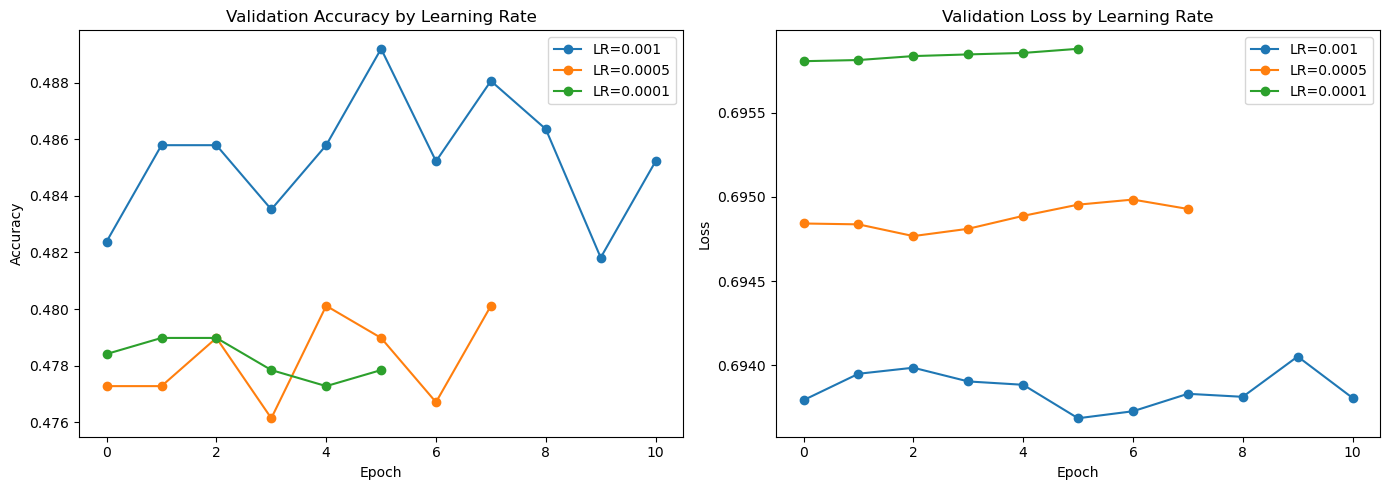

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
for lr, hist in histories.items():
    plt.plot(hist.history['val_accuracy'], marker='o', label=f'LR={lr}')
plt.title('Validation Accuracy by Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
for lr, hist in histories.items():
    plt.plot(hist.history['val_loss'], marker='o', label=f'LR={lr}')
plt.title('Validation Loss by Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

After testing different learning rates, 0.001 gave the best performance with the highest validation accuracy (~0.489) and lowest stable loss (~0.6938). It enabled faster and more effective learning compared to smaller rates, making it the optimal choice.

In [12]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Load best performing model
best_model = load_model("model_lr_0.001.keras")

 1/28 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step

2025-05-27 19:47:39.818937: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step 
Final Test Accuracy (tuned LR): 0.5210


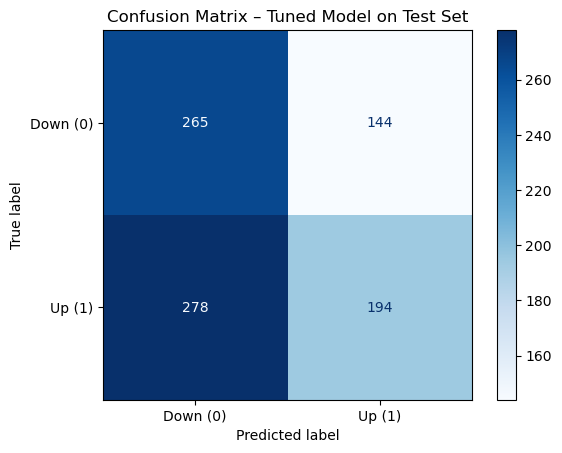

In [14]:
# Predict
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int").flatten()

# Accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Final Test Accuracy (tuned LR): {test_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Down (0)", "Up (1)"]).plot(cmap="Blues")
plt.title("Confusion Matrix – Tuned Model on Test Set")
plt.show()

**Reflection on the final model and confusion matrix**

After tuning the learning rate, the final test accuracy reached 52.1%, slightly outperforming earlier configurations. Among the three learning rates tested (0.001, 0.0005, 0.0001), 0.001 consistently showed better validation accuracy and lower validation loss across epochs, making it the optimal choice. The confusion matrix for this tuned model reflects more accurate predictions across both classes, especially a notable improvement in identifying the “Up” (1) class. This indicates that proper learning rate tuning helped the model learn meaningful patterns without overshooting or stagnating, ultimately leading to more balanced and reliable performance on unseen data.